In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import tqdm
from einops import rearrange, repeat
import numpy as np
import pytorch_lightning
from pytorch_lightning.utilities import move_data_to_device
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import linear_sum_assignment

from case_studies.dc2_mdt.utils.reverse_markov_learning import RMLDiffusion
from case_studies.dc2_mdt.utils.resample import SigmoidSampler
from case_studies.dc2_mdt.utils.new_simulate_image import ImageSimulator

In [3]:
image_size = 8
max_objects = 2
image_normalize_strategy = "linear_scale"

## RML

In [4]:
class FourierMLP(nn.Module):
    def __init__(self, data_shape, num_layers, hidden_ch):
        super().__init__()
        self.data_shape = [data_shape]

        self.register_buffer(
            "timestep_coeff", torch.linspace(start=0.1, end=100, steps=hidden_ch)[None]
        )  # (1, hidden)
        self.timestep_phase = nn.Parameter(torch.randn(hidden_ch)[None])  # (1, hidden)
        self.input_embed = nn.Sequential(
            nn.Linear(int(np.prod(data_shape)), hidden_ch),
            nn.GELU(),
            nn.Linear(hidden_ch, hidden_ch)
        )
        self.timestep_embed = nn.Sequential(
            nn.Linear(2 * hidden_ch, hidden_ch),
            nn.GELU(),
            nn.Linear(hidden_ch, hidden_ch),
        )
        self.cond_embed = nn.Sequential(
            nn.Linear(2, hidden_ch),
            nn.GELU(),
            nn.Linear(hidden_ch, hidden_ch),
        )
        self.image_embed = nn.Sequential(
            nn.Linear(image_size * image_size, hidden_ch),
            nn.GELU(),
            nn.Linear(hidden_ch, hidden_ch)
        )
        self.layers = nn.Sequential(
            nn.Linear(hidden_ch * 3 + int(np.prod(data_shape)), hidden_ch), 
            nn.GELU(),
            *[
                nn.Sequential(nn.Linear(hidden_ch, hidden_ch), nn.GELU())
                for _ in range(num_layers)
            ],
            nn.Linear(hidden_ch, int(np.prod(data_shape))),
        )

    def forward(self, x, t, *, image, cond, epsilon, is_training):
        if is_training:
            t = t.unsqueeze(-1)  # (b, m, 1)
            sin_embed_t = torch.sin(
                (self.timestep_coeff.unsqueeze(0) * t.float()) + self.timestep_phase.unsqueeze(0)
            )
            cos_embed_t = torch.cos(
                (self.timestep_coeff.unsqueeze(0) * t.float()) + self.timestep_phase.unsqueeze(0)
            )
            embed_t = self.timestep_embed(
                rearrange(torch.stack([sin_embed_t, cos_embed_t], dim=0), 
                          "d b m w -> b m (d w)")
            )  # (b, m, hidden)
            embed_xt = self.input_embed(x.flatten(2))  # (b, m, hidden)
            embed_image = self.image_embed(image.flatten(1))  # (b, hidden)
            embed_image = repeat(embed_image, "b hidden -> b m hidden", m=t.shape[1])
            embed_cond = self.cond_embed(cond.flatten(1))  # (b, hidden)
            embed_cond = repeat(embed_cond, "b hidden -> b m hidden", m=t.shape[1])
            out = self.layers(
                torch.cat([embed_xt + embed_t, 
                           embed_cond, 
                           embed_image, 
                           epsilon.flatten(2)], dim=-1)
            )
            return out.view(x.shape)
        t = t.clone()
        image = image.clone()
        t = t.unsqueeze(-1)  # (b, 1)
        sin_embed_t = torch.sin(
            (self.timestep_coeff * t.float()) + self.timestep_phase
        )  # (b, hidden)
        cos_embed_t = torch.cos(
            (self.timestep_coeff * t.float()) + self.timestep_phase
        )
        embed_t = self.timestep_embed(
            rearrange(torch.stack([sin_embed_t, cos_embed_t], dim=0), 
                      "d b w -> b (d w)")
        )
        embed_xt = self.input_embed(x.flatten(1))
        embed_image = self.image_embed(image.flatten(1))
        embed_cond = self.cond_embed(cond.flatten(1))
        out = self.layers(
            torch.cat([embed_xt + embed_t, 
                       embed_cond, 
                       embed_image, 
                       epsilon.flatten(1)], dim=-1)
        )
        return out.view(x.shape)

In [5]:
device = torch.device("cuda:7")
batch_size = 1024
training_time_steps = 1000
training_iters = 50_000
ddim_steps = 51
ddim_eta = 0.0  # use 0.0 for better results when max_objects >= 2
log_freq = 500
seed = 1201023
pytorch_lightning.seed_everything(seed)

Seed set to 1201023


1201023

In [6]:
image_simulator = ImageSimulator(img_height=image_size,
                                 img_width=image_size,
                                 max_objects=max_objects,
                                 psf_stdev=1.0,
                                 flux_alpha=10.0,
                                 flux_beta=0.01,
                                 pad=0,
                                 always_max_count=False,
                                 constant_locs=False,
                                 coadd_images=True).to(device=device)

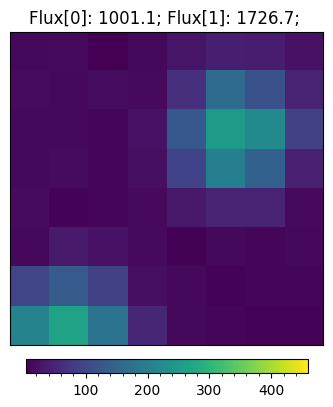

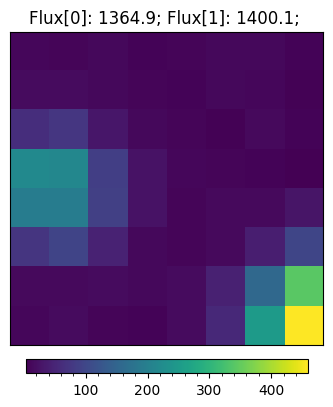

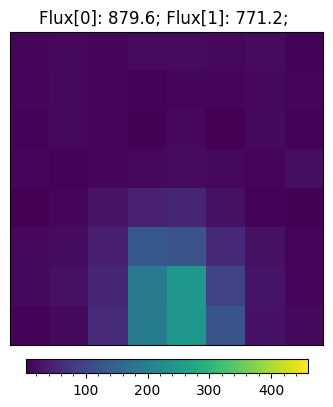

In [7]:
sim_out = image_simulator.generate(3, seed=7272)
img_min = sim_out["images"].min()
img_max = sim_out["images"].max()
for sub_img, flux in zip(sim_out["images"], sim_out["fluxes"]):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    im = ax.imshow(sub_img.cpu(), vmin=img_min, vmax=img_max)
    ax.set_xticks([])
    ax.set_yticks([])
    if flux.shape[0] == 1:
        ax.set_title(f"Flux: {flux.item():.1f}")
    else:
        t = ""
        for i, f in enumerate(flux):
            t += f"Flux[{i}]: {f.item():.1f}; "
        ax.set_title(t)
    cb = fig.colorbar(im, ax=ax, 
                      location="bottom", shrink=0.6,
                      anchor=(0.5, 2.0))
    cb.minorticks_on()
    fig.tight_layout()
    fig.show()

In [8]:
training_diffusion = RMLDiffusion(num_timesteps=training_time_steps,
                                  num_sampling_steps=ddim_steps,
                                  m=16,
                                  lambda_=1.0,
                                  beta=0.5)
sampling_diffusion = training_diffusion
# schedule_sampler = create_named_schedule_sampler("uniform", training_diffusion)
# schedule_sampler = SpeedSampler(diffusion=training_diffusion,
#                                 lam=0.6,
#                                 k=5,
#                                 tau=700)
schedule_sampler = SigmoidSampler(training_diffusion, 0)

In [9]:
my_net = FourierMLP(data_shape=[2, 2], 
                    num_layers=8, 
                    hidden_ch=64).to(device=device)
my_optimizer = torch.optim.Adam(my_net.parameters(), lr=1e-3, amsgrad=True)
my_scheduler = torch.optim.lr_scheduler.MultiStepLR(my_optimizer, milestones=[training_iters // 4 * 3], gamma=0.1)

In [10]:
# max_flux_boundary = 2000.0
# def encode_flux(flux: torch.Tensor):
#     assert flux.min() >= 0.0
#     flux = flux.clamp(max=max_flux_boundary)
#     return (torch.log1p(flux) / torch.log1p(torch.tensor(max_flux_boundary))) * 2 - 1

# def decode_flux(flux_minus1_to_1: torch.Tensor):
#     assert flux_minus1_to_1.min() >= -1.0 and flux_minus1_to_1.max() <= 1.0
#     return torch.expm1((flux_minus1_to_1 + 1) / 2 * torch.log1p(torch.tensor(max_flux_boundary)))

In [11]:
max_flux_boundary = 2000.0
def encode_flux(flux: torch.Tensor):
    assert flux.min() >= 0.0
    flux = flux.clamp(max=max_flux_boundary)
    return (flux / max_flux_boundary) * 2 - 1

def decode_flux(flux_minus1_to_1: torch.Tensor):
    assert flux_minus1_to_1.min() >= -1.0 and flux_minus1_to_1.max() <= 1.0
    return (flux_minus1_to_1 + 1) / 2 * max_flux_boundary

In [12]:
def encode_x_start(catalog):
    n_sources = catalog["counts"]  # (b, )
    locs = catalog["locs"]  # (b, m, 2)
    fluxes = catalog["fluxes"].unsqueeze(-1)  # (b, m, 1)
    n_sources = (n_sources.unsqueeze(-1) >= torch.arange(1, locs.shape[1] + 1, device=locs.device)).unsqueeze(-1)  # (b, m, 1)
    x_start = torch.cat([n_sources * 2 - 1, locs / image_size * 2 - 1, encode_flux(fluxes)], dim=-1)  # (b, m, 4)
    dist_to_ori = torch.sqrt(((x_start[..., 1:3] + 1) ** 2).sum(dim=-1))
    sorted_index = dist_to_ori.argsort(dim=-1, descending=True)  # (b, m)
    return torch.take_along_dim(x_start, repeat(sorted_index, "... -> ... r", r=4), dim=-2)  # (b, m, 4)

In [13]:
def decode_x_start(output_x_start):
    n_sources = output_x_start[..., 0] > 0.0  # (b, m)
    locs = (output_x_start[..., 1:3] + 1) / 2 * image_size  # (b, m, 2)
    fluxes = decode_flux(output_x_start[..., 3])  # (b, m)
    return {
        "counts": n_sources.sum(dim=-1),
        "n_sources": n_sources.int(),
        "locs": locs,
        "fluxes": fluxes,
    }

In [14]:
def normalize_image(input_image):
    match image_normalize_strategy:
        case "none":
            output_image = input_image
        case "log":
            output_image = torch.log1p(input_image)
        case "linear_scale":
            output_image = input_image / 1000
        case _:
            raise NotImplementedError()
    return output_image

In [15]:
my_net.train()
loss_record = []
for i in tqdm.tqdm(list(range(training_iters))):
    catalog = image_simulator.generate(batch_size)
    t, batch_sample_weights, batch_loss_weights = schedule_sampler.sample(batch_size, device=device)
    input_image = catalog["images"]  # (b, h, w)
    input_image = normalize_image(input_image)
    cond, x_start, _flux = encode_x_start(catalog).split([1, 2, 1], dim=-1)
    train_loss_args = {
        "model": my_net,
        "x_start": x_start,
        "t": t,
        "loss_weights": batch_loss_weights
    }
    loss = training_diffusion.training_losses(**train_loss_args, 
                                              model_kwargs={"image": input_image,
                                                            "cond": cond})["loss"]
    loss = (loss * batch_sample_weights).mean()
    loss_record.append(loss.item())
    my_optimizer.zero_grad()
    loss.backward()
    my_optimizer.step()
    my_scheduler.step()
    if (i + 1) % log_freq == 0:
        print(f"[{i + 1}/{training_iters}] loss: {loss.item():.3e}")

  1%|          | 506/50000 [00:10<17:28, 47.19it/s]

[500/50000] loss: 2.010e-01


  2%|▏         | 1005/50000 [00:20<16:28, 49.58it/s]

[1000/50000] loss: 1.852e-01


  3%|▎         | 1507/50000 [00:31<17:33, 46.01it/s]

[1500/50000] loss: 1.740e-01


  4%|▍         | 2008/50000 [00:41<16:53, 47.33it/s]

[2000/50000] loss: 1.198e-01


  5%|▌         | 2509/50000 [00:52<16:14, 48.71it/s]

[2500/50000] loss: 8.864e-02


  6%|▌         | 3009/50000 [01:02<16:55, 46.27it/s]

[3000/50000] loss: 7.558e-02


  7%|▋         | 3505/50000 [01:12<15:48, 49.03it/s]

[3500/50000] loss: 6.746e-02


  8%|▊         | 4010/50000 [01:23<15:20, 49.98it/s]

[4000/50000] loss: 6.142e-02


  9%|▉         | 4506/50000 [01:33<14:50, 51.10it/s]

[4500/50000] loss: 5.818e-02


 10%|█         | 5008/50000 [01:43<14:48, 50.61it/s]

[5000/50000] loss: 6.285e-02


 11%|█         | 5505/50000 [01:53<15:11, 48.79it/s]

[5500/50000] loss: 5.799e-02


 12%|█▏        | 6006/50000 [02:03<14:51, 49.34it/s]

[6000/50000] loss: 5.580e-02


 13%|█▎        | 6509/50000 [02:13<14:51, 48.77it/s]

[6500/50000] loss: 5.534e-02


 14%|█▍        | 7010/50000 [02:23<14:06, 50.78it/s]

[7000/50000] loss: 5.907e-02


 15%|█▌        | 7505/50000 [02:33<14:20, 49.41it/s]

[7500/50000] loss: 5.218e-02


 16%|█▌        | 8008/50000 [02:44<14:08, 49.47it/s]

[8000/50000] loss: 5.328e-02


 17%|█▋        | 8509/50000 [02:54<13:47, 50.16it/s]

[8500/50000] loss: 5.032e-02


 18%|█▊        | 9010/50000 [03:04<13:52, 49.25it/s]

[9000/50000] loss: 4.908e-02


 19%|█▉        | 9509/50000 [03:14<13:31, 49.88it/s]

[9500/50000] loss: 5.433e-02


 20%|██        | 10006/50000 [03:24<13:27, 49.53it/s]

[10000/50000] loss: 5.040e-02


 21%|██        | 10507/50000 [03:34<13:25, 49.06it/s]

[10500/50000] loss: 5.099e-02


 22%|██▏       | 11005/50000 [03:44<13:13, 49.16it/s]

[11000/50000] loss: 5.174e-02


 23%|██▎       | 11507/50000 [03:54<13:08, 48.81it/s]

[11500/50000] loss: 4.804e-02


 24%|██▍       | 12008/50000 [04:04<12:42, 49.85it/s]

[12000/50000] loss: 4.860e-02


 25%|██▌       | 12509/50000 [04:14<12:38, 49.42it/s]

[12500/50000] loss: 4.958e-02


 26%|██▌       | 13005/50000 [04:24<12:17, 50.18it/s]

[13000/50000] loss: 4.601e-02


 27%|██▋       | 13506/50000 [04:34<12:01, 50.59it/s]

[13500/50000] loss: 4.607e-02


 28%|██▊       | 14009/50000 [04:44<12:11, 49.21it/s]

[14000/50000] loss: 5.024e-02


 29%|██▉       | 14507/50000 [04:54<11:57, 49.43it/s]

[14500/50000] loss: 4.633e-02


 30%|███       | 15006/50000 [05:04<11:32, 50.52it/s]

[15000/50000] loss: 4.503e-02


 31%|███       | 15507/50000 [05:14<11:37, 49.47it/s]

[15500/50000] loss: 4.554e-02


 32%|███▏      | 16007/50000 [05:24<11:20, 49.97it/s]

[16000/50000] loss: 4.769e-02


 33%|███▎      | 16506/50000 [05:34<11:04, 50.43it/s]

[16500/50000] loss: 4.635e-02


 34%|███▍      | 17009/50000 [05:44<11:03, 49.74it/s]

[17000/50000] loss: 4.533e-02


 35%|███▌      | 17505/50000 [05:54<11:01, 49.13it/s]

[17500/50000] loss: 4.406e-02


 36%|███▌      | 18006/50000 [06:04<10:35, 50.31it/s]

[18000/50000] loss: 4.369e-02


 37%|███▋      | 18510/50000 [06:14<10:33, 49.72it/s]

[18500/50000] loss: 4.449e-02


 38%|███▊      | 19008/50000 [06:24<10:17, 50.23it/s]

[19000/50000] loss: 4.513e-02


 39%|███▉      | 19505/50000 [06:34<10:07, 50.23it/s]

[19500/50000] loss: 4.680e-02


 40%|████      | 20005/50000 [06:44<10:03, 49.67it/s]

[20000/50000] loss: 4.305e-02


 41%|████      | 20510/50000 [06:54<09:47, 50.21it/s]

[20500/50000] loss: 4.702e-02


 42%|████▏     | 21009/50000 [07:04<09:36, 50.25it/s]

[21000/50000] loss: 4.017e-02


 43%|████▎     | 21506/50000 [07:14<09:29, 50.00it/s]

[21500/50000] loss: 4.032e-02


 44%|████▍     | 22007/50000 [07:24<09:14, 50.49it/s]

[22000/50000] loss: 4.431e-02


 45%|████▌     | 22506/50000 [07:33<09:19, 49.10it/s]

[22500/50000] loss: 4.160e-02


 46%|████▌     | 23010/50000 [07:44<08:57, 50.17it/s]

[23000/50000] loss: 4.087e-02


 47%|████▋     | 23506/50000 [07:53<08:42, 50.68it/s]

[23500/50000] loss: 4.178e-02


 48%|████▊     | 24006/50000 [08:03<08:45, 49.44it/s]

[24000/50000] loss: 4.289e-02


 49%|████▉     | 24506/50000 [08:14<08:40, 49.00it/s]

[24500/50000] loss: 4.156e-02


 50%|█████     | 25007/50000 [08:24<08:24, 49.57it/s]

[25000/50000] loss: 4.154e-02


 51%|█████     | 25509/50000 [08:34<08:11, 49.84it/s]

[25500/50000] loss: 4.146e-02


 52%|█████▏    | 26007/50000 [08:44<07:49, 51.11it/s]

[26000/50000] loss: 4.185e-02


 53%|█████▎    | 26505/50000 [08:53<07:48, 50.15it/s]

[26500/50000] loss: 4.425e-02


 54%|█████▍    | 27010/50000 [09:03<07:22, 51.91it/s]

[27000/50000] loss: 4.166e-02


 55%|█████▌    | 27510/50000 [09:13<07:22, 50.86it/s]

[27500/50000] loss: 4.233e-02


 56%|█████▌    | 28008/50000 [09:23<07:17, 50.24it/s]

[28000/50000] loss: 4.089e-02


 57%|█████▋    | 28510/50000 [09:33<06:21, 56.30it/s]

[28500/50000] loss: 3.960e-02


 58%|█████▊    | 29006/50000 [09:43<07:27, 46.94it/s]

[29000/50000] loss: 4.365e-02


 59%|█████▉    | 29506/50000 [09:54<07:18, 46.74it/s]

[29500/50000] loss: 3.939e-02


 60%|██████    | 30007/50000 [10:03<06:15, 53.28it/s]

[30000/50000] loss: 3.891e-02


 61%|██████    | 30505/50000 [10:13<06:08, 52.86it/s]

[30500/50000] loss: 4.331e-02


 62%|██████▏   | 31009/50000 [10:23<06:15, 50.58it/s]

[31000/50000] loss: 3.682e-02


 63%|██████▎   | 31507/50000 [10:33<06:07, 50.32it/s]

[31500/50000] loss: 4.112e-02


 64%|██████▍   | 32010/50000 [10:43<06:00, 49.94it/s]

[32000/50000] loss: 3.994e-02


 65%|██████▌   | 32510/50000 [10:53<05:44, 50.84it/s]

[32500/50000] loss: 4.184e-02


 66%|██████▌   | 33008/50000 [11:03<05:34, 50.79it/s]

[33000/50000] loss: 4.381e-02


 67%|██████▋   | 33506/50000 [11:13<05:29, 50.02it/s]

[33500/50000] loss: 3.997e-02


 68%|██████▊   | 34009/50000 [11:23<05:08, 51.85it/s]

[34000/50000] loss: 4.195e-02


 69%|██████▉   | 34508/50000 [11:32<05:06, 50.60it/s]

[34500/50000] loss: 4.204e-02


 70%|███████   | 35006/50000 [11:42<04:55, 50.76it/s]

[35000/50000] loss: 3.892e-02


 71%|███████   | 35509/50000 [11:52<04:48, 50.25it/s]

[35500/50000] loss: 4.230e-02


 72%|███████▏  | 36007/50000 [12:02<04:37, 50.35it/s]

[36000/50000] loss: 4.138e-02


 73%|███████▎  | 36509/50000 [12:12<04:24, 50.92it/s]

[36500/50000] loss: 3.961e-02


 74%|███████▍  | 37005/50000 [12:21<04:17, 50.47it/s]

[37000/50000] loss: 4.072e-02


 75%|███████▌  | 37506/50000 [12:31<04:07, 50.44it/s]

[37500/50000] loss: 3.995e-02


 76%|███████▌  | 38010/50000 [12:41<03:57, 50.38it/s]

[38000/50000] loss: 3.938e-02


 77%|███████▋  | 38507/50000 [12:51<03:47, 50.46it/s]

[38500/50000] loss: 3.847e-02


 78%|███████▊  | 39007/50000 [13:00<03:13, 56.74it/s]

[39000/50000] loss: 3.968e-02


 79%|███████▉  | 39508/50000 [13:10<03:27, 50.48it/s]

[39500/50000] loss: 3.878e-02


 80%|████████  | 40010/50000 [13:20<03:17, 50.54it/s]

[40000/50000] loss: 3.852e-02


 81%|████████  | 40508/50000 [13:30<03:09, 50.16it/s]

[40500/50000] loss: 3.807e-02


 82%|████████▏ | 41007/50000 [13:39<02:58, 50.47it/s]

[41000/50000] loss: 3.788e-02


 83%|████████▎ | 41505/50000 [13:49<02:47, 50.65it/s]

[41500/50000] loss: 3.750e-02


 84%|████████▍ | 42009/50000 [13:59<02:38, 50.49it/s]

[42000/50000] loss: 4.092e-02


 85%|████████▌ | 42507/50000 [14:09<02:21, 52.86it/s]

[42500/50000] loss: 3.811e-02


 86%|████████▌ | 43005/50000 [14:18<02:15, 51.78it/s]

[43000/50000] loss: 3.855e-02


 87%|████████▋ | 43506/50000 [14:28<02:13, 48.60it/s]

[43500/50000] loss: 3.646e-02


 88%|████████▊ | 44009/50000 [14:38<01:59, 50.29it/s]

[44000/50000] loss: 3.874e-02


 89%|████████▉ | 44509/50000 [14:48<01:51, 49.45it/s]

[44500/50000] loss: 3.914e-02


 90%|█████████ | 45005/50000 [14:58<01:41, 49.01it/s]

[45000/50000] loss: 3.687e-02


 91%|█████████ | 45507/50000 [15:08<01:28, 50.78it/s]

[45500/50000] loss: 3.658e-02


 92%|█████████▏| 46005/50000 [15:17<01:16, 52.04it/s]

[46000/50000] loss: 4.097e-02


 93%|█████████▎| 46510/50000 [15:27<01:09, 50.49it/s]

[46500/50000] loss: 3.786e-02


 94%|█████████▍| 47008/50000 [15:37<00:59, 50.23it/s]

[47000/50000] loss: 3.850e-02


 95%|█████████▌| 47506/50000 [15:47<00:49, 50.48it/s]

[47500/50000] loss: 3.802e-02


 96%|█████████▌| 48009/50000 [15:57<00:40, 49.04it/s]

[48000/50000] loss: 3.649e-02


 97%|█████████▋| 48510/50000 [16:07<00:28, 52.06it/s]

[48500/50000] loss: 3.844e-02


 98%|█████████▊| 49008/50000 [16:16<00:19, 50.47it/s]

[49000/50000] loss: 3.539e-02


 99%|█████████▉| 49508/50000 [16:26<00:09, 50.83it/s]

[49500/50000] loss: 3.846e-02


100%|██████████| 50000/50000 [16:36<00:00, 50.20it/s]

[50000/50000] loss: 3.918e-02


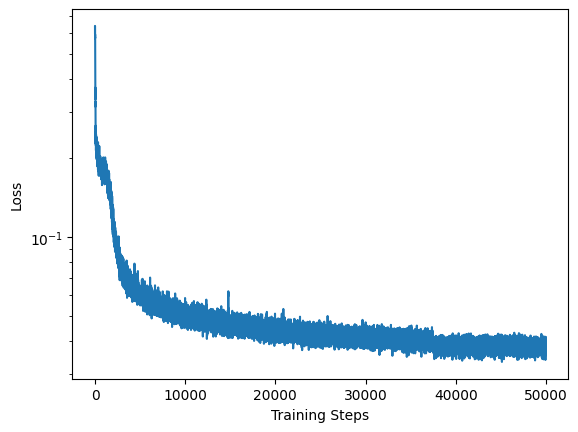

In [16]:
plt.plot(loss_record)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()

In [27]:
my_net.eval()
val_images = []
val_true_cat = []
val_est_cat = []
with torch.inference_mode():
    for i in tqdm.tqdm(list(range(10_000))):
        val_catalog = image_simulator.generate(batch_size=1024)
        input_image = val_catalog["images"]
        val_images.append(input_image.cpu())
        input_image = normalize_image(input_image)
        val_catalog = decode_x_start(encode_x_start(val_catalog))
        val_true_cat.append(move_data_to_device(val_catalog, "cpu"))
        cond, x_start, flux = encode_x_start(val_catalog).split([1, 2, 1], dim=-1)
        diffusion_sampling_config = {
            "model": my_net,
            "shape": (1024, max_objects, 2),
            "clip_denoised": True,
            "model_kwargs": {"image": input_image,
                             "cond": cond}
        }
        sample = sampling_diffusion.ddim_sample_loop(**diffusion_sampling_config, eta=ddim_eta)
        val_est_cat.append(move_data_to_device(
            decode_x_start(torch.cat([cond, sample, flux], dim=-1)), 
        "cpu"))

100%|██████████| 10000/10000 [24:05<00:00,  6.92it/s]


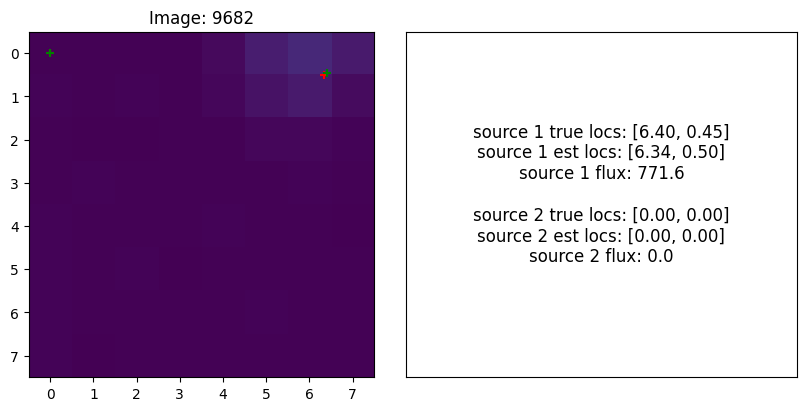

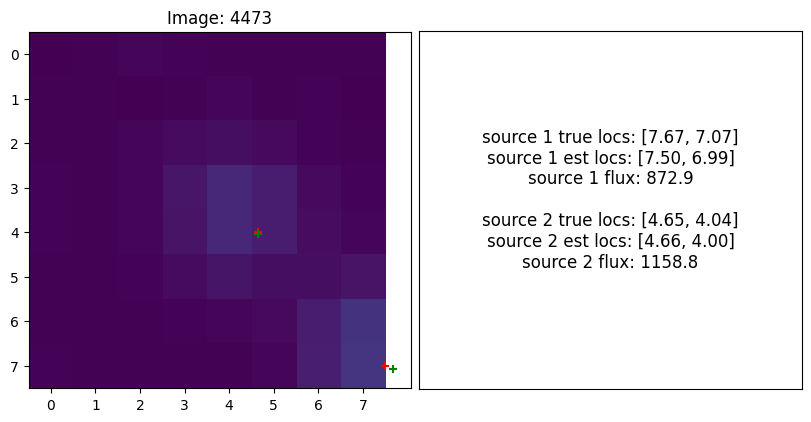

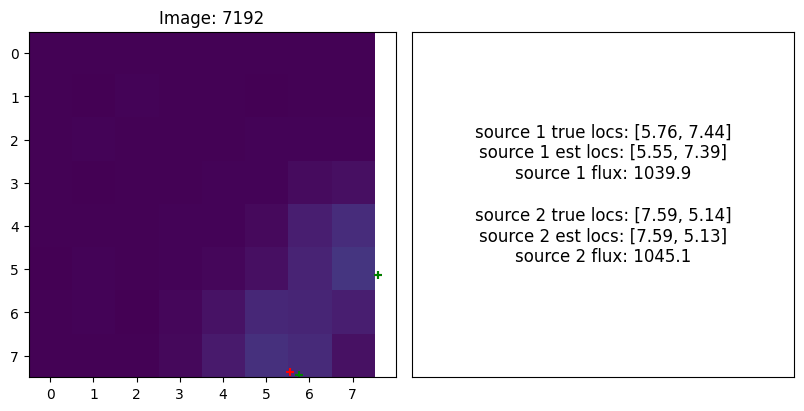

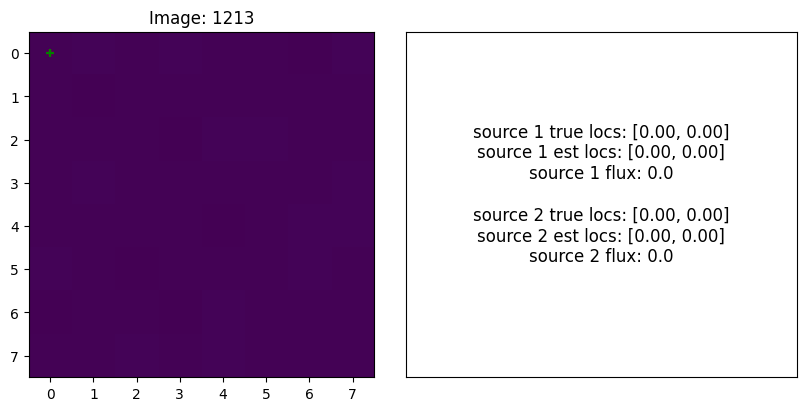

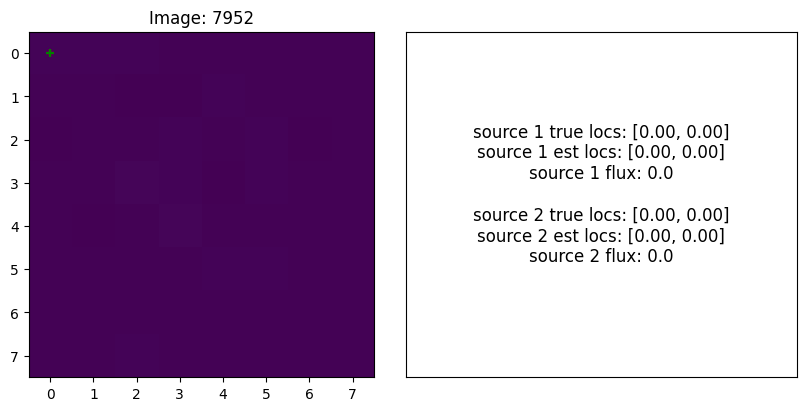

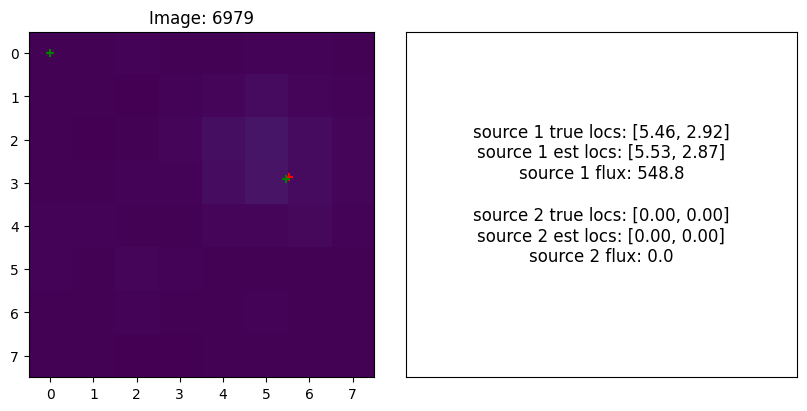

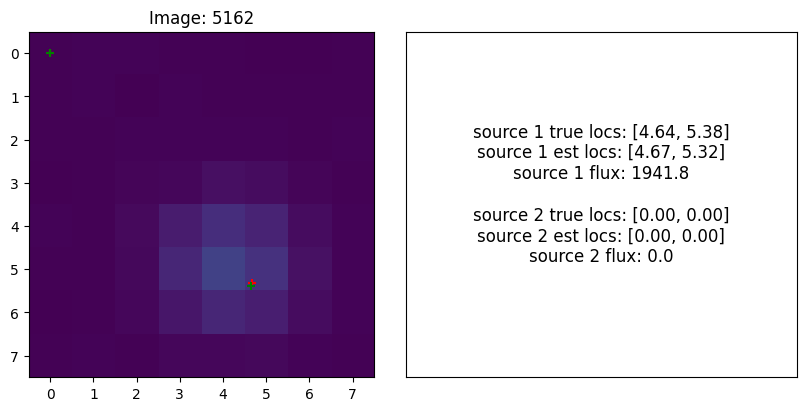

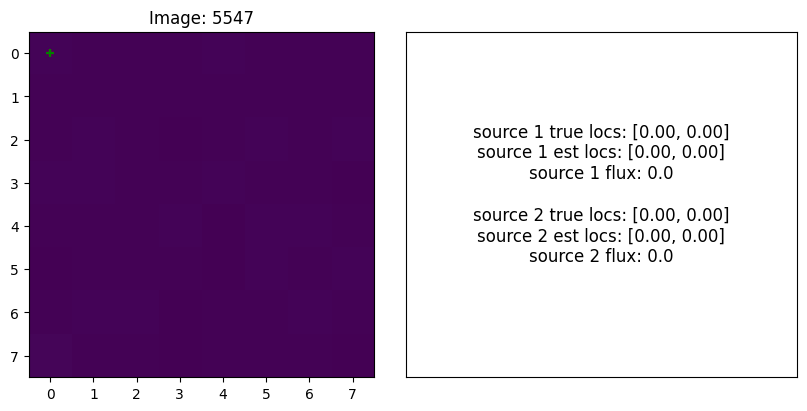

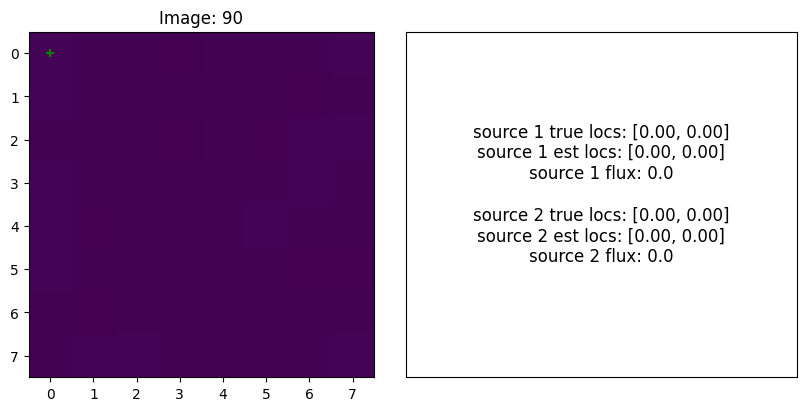

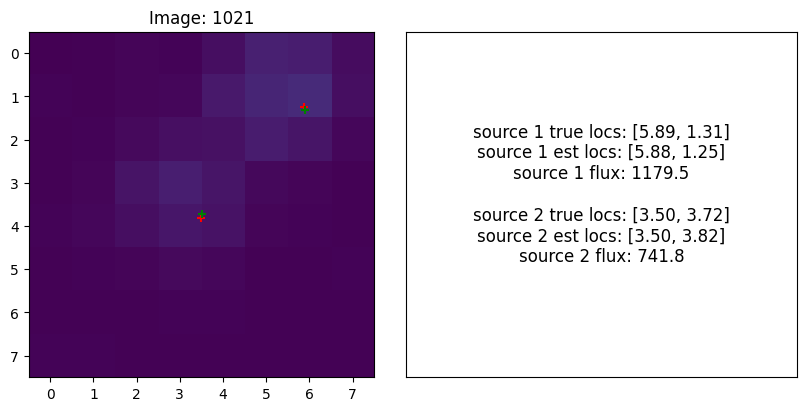

In [28]:
img_min = torch.stack(val_images).min()
img_max = torch.stack(val_images).max()
for test_i in torch.randperm(len(val_images))[:10]:
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)
    axes[0].imshow(val_images[test_i][0], 
                    vmin=img_min, 
                    vmax=img_max)
    est_locs_x = val_est_cat[test_i]["locs"][0, :, 1]
    est_locs_y = val_est_cat[test_i]["locs"][0, :, 0]
    est_fluxes = val_est_cat[test_i]["fluxes"][0]
    axes[0].scatter(est_locs_x,
                    est_locs_y,
                    s=30, c="red", marker="+")
    true_locs_x = val_true_cat[test_i]["locs"][0, :, 1]
    true_locs_y = val_true_cat[test_i]["locs"][0, :, 0]
    true_fluxes = val_true_cat[test_i]["fluxes"][0]
    axes[0].scatter(true_locs_x,
                    true_locs_y,
                    s=30, c="green", marker="+")
    axes[0].set_title(f"Image: {test_i}")
    axes[0].set_xticks(range(8))
    axes[0].set_yticks(range(8))
    axes[1].text(0.5, 0.5, 
                    f"source 1 true locs: [{true_locs_x[0]:.2f}, {true_locs_y[0]:.2f}]\n"
                    f"source 1 est locs: [{est_locs_x[0]:.2f}, {est_locs_y[0]:.2f}]\n"
                    f"source 1 flux: {est_fluxes[0]:.1f}\n\n"
                    f"source 2 true locs: [{true_locs_x[1]:.2f}, {true_locs_y[1]:.2f}]\n"
                    f"source 2 est locs: [{est_locs_x[1]:.2f}, {est_locs_y[1]:.2f}]\n"
                    f"source 2 flux: {true_fluxes[1]:.1f}\n", 
                    ha="center", va="center", fontsize=12)
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    fig.show()

In [29]:
diffusion_pred_ns = []
diffusion_true_ns = []
diffusion_pred_locs = []
diffusion_true_locs = []
diffusion_pred_fluxes = []
diffusion_true_fluxes = []
for ec, tc in zip(val_est_cat, val_true_cat, strict=True):
    diffusion_pred_ns.append(ec["n_sources"])
    diffusion_true_ns.append(tc["n_sources"])
    diffusion_pred_locs.append(ec["locs"])
    diffusion_true_locs.append(tc["locs"])
    diffusion_pred_fluxes.append(ec["fluxes"])
    diffusion_true_fluxes.append(tc["fluxes"])
diffusion_pred_ns = torch.cat(diffusion_pred_ns, dim=0)
diffusion_true_ns = torch.cat(diffusion_true_ns, dim=0)
diffusion_pred_locs = torch.cat(diffusion_pred_locs, dim=0)
diffusion_true_locs = torch.cat(diffusion_true_locs, dim=0)
diffusion_pred_fluxes = torch.cat(diffusion_pred_fluxes, dim=0)
diffusion_true_fluxes = torch.cat(diffusion_true_fluxes, dim=0)

In [30]:
diffusion_true_ns.shape, diffusion_pred_ns.shape

(torch.Size([10240000, 2]), torch.Size([10240000, 2]))

In [31]:
diffusion_pred_locs.shape, diffusion_true_locs.shape

(torch.Size([10240000, 2, 2]), torch.Size([10240000, 2, 2]))

In [32]:
diffusion_pred_fluxes.shape, diffusion_true_fluxes.shape

(torch.Size([10240000, 2]), torch.Size([10240000, 2]))

In [33]:
def plot_cm(d_pred_bin_index, d_true_bin_index, bin_num, bin_labels, axis_label):
    d_cm = torch.zeros(bin_num, bin_num, dtype=torch.int)
    for ri in range(d_cm.shape[0]):
        for ci in range(d_cm.shape[1]):
            d_cm[ri, ci] = ((d_pred_bin_index == ri) & (d_true_bin_index == ci)).sum()

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    sns.heatmap(d_cm,
                annot=True,
                fmt="d", cmap="Greens", cbar=False,
                xticklabels=bin_labels,
                yticklabels=bin_labels,
                ax=ax)
    ax.set_xlabel(f"True {axis_label}")
    ax.set_ylabel(f"Pred {axis_label}")
    ax.set_title("Diffusion")
    fig.show()

    # fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    # sns.heatmap(d_cm / torch.sum(d_cm, dim=0, keepdim=True),
    #             annot=True,
    #             fmt=".2f", cmap="Greens", cbar=False,
    #             xticklabels=bin_labels,
    #             yticklabels=bin_labels,
    #             ax=ax)
    # ax.set_xlabel(f"True {axis_label}")
    # ax.set_ylabel(f"Pred {axis_label}")
    # ax.set_title("Diffusion (CM in Percent)")
    # fig.show()

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    sns.heatmap(((d_cm - d_cm.T) / torch.minimum(d_cm, d_cm.T).clamp(min=1)).abs(),
                annot=(d_cm - d_cm.T) / torch.minimum(d_cm, d_cm.T).clamp(min=1),
                fmt=".2f", cmap="Greens", cbar=False,
                xticklabels=bin_labels,
                yticklabels=bin_labels,
                ax=ax)
    ax.set_xlabel(f"True {axis_label}")
    ax.set_ylabel(f"Pred {axis_label}")
    ax.set_title("Diffusion (Asymmetry Factor)")
    fig.show()

In [34]:
def inclusive_bucektize(input_t, boundary):
    new_boundary = boundary.clone()
    new_boundary[0] -= 1e-3
    new_boundary[-1] += 1e-3
    b_index = torch.bucketize(input_t, new_boundary)
    assert (b_index > 0).all()
    assert (b_index < new_boundary.shape[0]).all()
    return b_index - 1

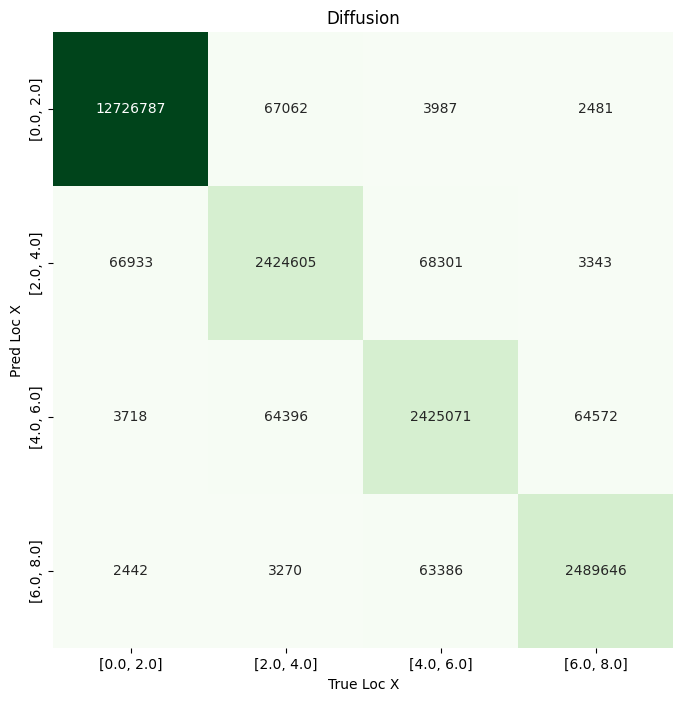

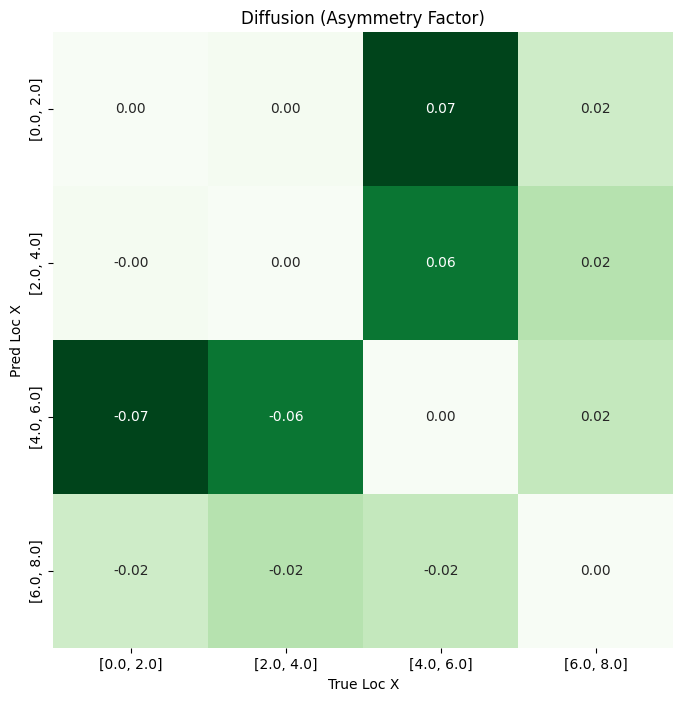

In [35]:
locs_bin_boundary = torch.linspace(0.0, 8.0, 5)
d_pred_locs_x_bin_index = inclusive_bucektize(diffusion_pred_locs[..., 1], locs_bin_boundary)
d_true_locs_x_bin_index = inclusive_bucektize(diffusion_true_locs[..., 1], locs_bin_boundary)
plot_cm(d_pred_locs_x_bin_index, d_true_locs_x_bin_index, 
        bin_num=4, bin_labels=[f"[{bl1:.1f}, {bl2:.1f}]" 
                               for bl1, bl2 in zip(locs_bin_boundary[:-1], 
                                                   locs_bin_boundary[1:])], 
        axis_label="Loc X")

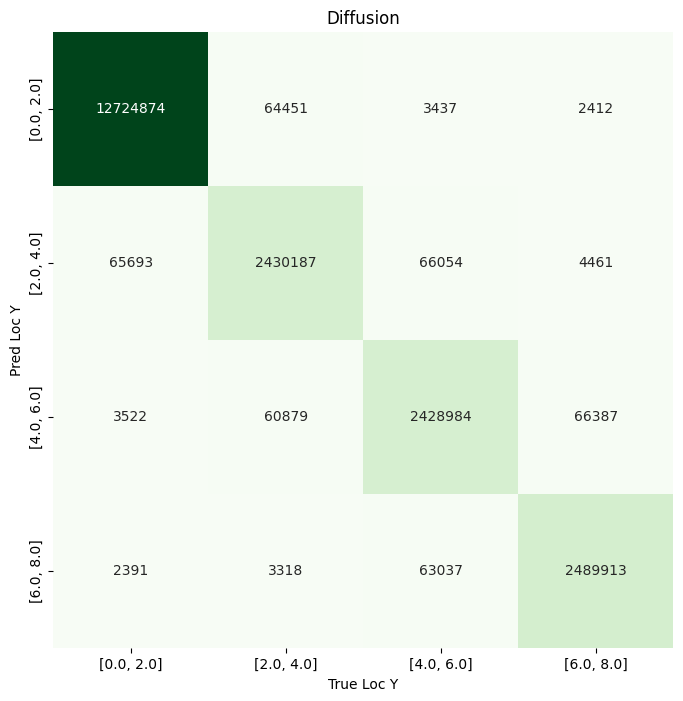

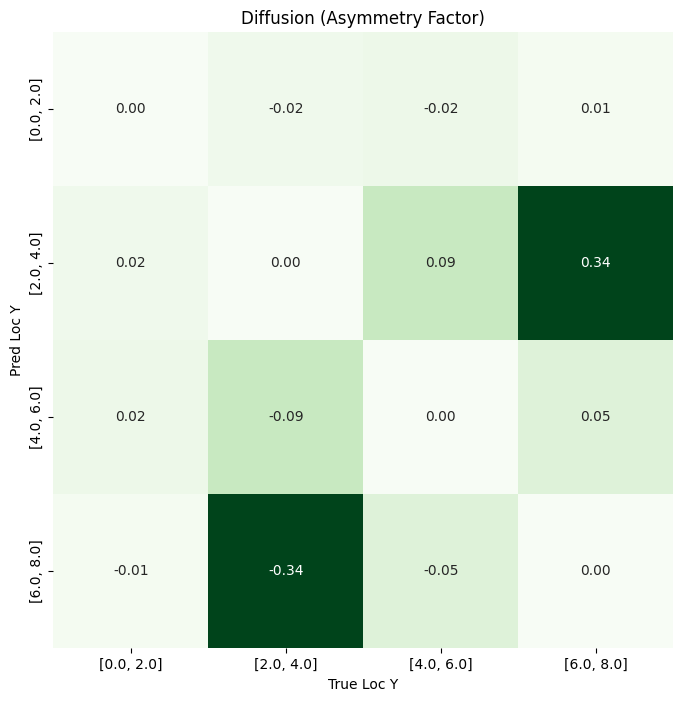

In [38]:
locs_bin_boundary = torch.linspace(0.0, 8.0, 5)
d_pred_locs_y_bin_index = inclusive_bucektize(diffusion_pred_locs[..., 0], locs_bin_boundary)
d_true_locs_y_bin_index = inclusive_bucektize(diffusion_true_locs[..., 0], locs_bin_boundary)
plot_cm(d_pred_locs_y_bin_index, d_true_locs_y_bin_index, 
        bin_num=4, bin_labels=[f"[{bl1:.1f}, {bl2:.1f}]" 
                               for bl1, bl2 in zip(locs_bin_boundary[:-1], 
                                                   locs_bin_boundary[1:])], 
        axis_label="Loc Y")